📚 Ransomware Behavioral Detection — Autoencoder Modeling

In this notebook, we shift from CNNs and LSTMs to a new approach:

    Autoencoders → Unsupervised anomaly detection

Each row in our dataset represents a short execution window (0.1 seconds) with statistical features.
Ransomware does not instantly reveal itself → its behavior evolves gradually.

While CNNs capture local patterns and LSTMs model sequences → Autoencoders aim to:

✅ Compress patterns into latent space → keep essential, generalizable info
✅ Learn to reconstruct normal (benign) sequences well
✅ Fail to reconstruct ransomware patterns (since they were never seen) → → → Higher reconstruction error → anomaly detection

In other words:

    We will train the Autoencoder only on benign sequences → any sequence with high reconstruction error will be flagged as ransomware.

This notebook will:

    Build and train Autoencoder on benign sequences.

    Detect ransomware sequences based on reconstruction error.


In [2]:

import os, random, numpy as np, pandas as pd, tensorflow as tf

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

DATA_PATH = "../Datasets/final_prepared_dataset.parquet"  
df = pd.read_parquet(DATA_PATH)

print("Data shape:", df.shape)
df.head()          


Data shape: (194466, 26)


,family,window_id,read_throughput,read_lba_var,write_throughput,write_lba_var,write_entropy,mem_read_count_4k,mem_read_count_2m,mem_read_count_mmio,...,mem_readwrite_entropy,mem_readwrite_count_4k,mem_readwrite_count_2m,mem_readwrite_count_mmio,mem_readwrite_gpa_var,mem_exec_count_4k,mem_exec_count_2m,mem_exec_count_mmio,mem_exec_gpa_var,label
0,AESCrypt,0,0.0,0.0,0.0,0.0,0.0,0,6,314,...,0.749489,0,0,14,3.023757e+19,0,0,89,4.227084e+19,0
1,AESCrypt,1,0.0,0.0,0.0,0.0,0.0,0,0,214,...,0.843179,0,0,1,0.000000e+00,0,0,6,2.081018e+19,0
2,AESCrypt,2,0.0,0.0,0.0,0.0,0.0,0,0,20,...,0.643699,0,0,1,0.000000e+00,0,0,5,2.437121e+19,0
3,AESCrypt,5,0.0,0.0,0.0,0.0,0.0,0,0,9,...,0.837807,0,0,2,9.921287e+16,0,0,6,3.505556e+19,0
4,AESCrypt,6,0.0,0.0,0.0,0.0,0.0,0,0,1,...,0.000000,0,0,0,0.000000e+00,0,0,1,0.000000e+00,0


In [3]:
# 1 --- Identify unique families and their general classification (benign/ransomware)
# We assume a family is 'benign' if its most frequent label is 0, and 'ransomware' if 1.
# This is a heuristic; ideally, domain knowledge confirms this.
family_classifications = {}
for family in df['family'].unique():
    # Get the mode of the 'label' for the current family
    mode_label = df[df['family'] == family]['label'].mode()
    if not mode_label.empty:
        family_classifications[family] = mode_label.iloc[0]
    else:
        family_classifications[family] = -1 # Indicates unknown or mixed without a clear mode

print("Family classifications (0=Benign, 1=Ransomware, -1=Unknown/Mixed):")
for family, label in family_classifications.items():
    print(f"  {family}: {label}")

benign_families = [family for family, label in family_classifications.items() if label == 0]
ransomware_families = [family for family, label in family_classifications.items() if label == 1]
unknown_families = [family for family, label in family_classifications.items() if label == -1]

print("\nIdentified Benign Families:", benign_families)
print("Identified Ransomware Families:", ransomware_families)
if unknown_families:
    print("Identified Unknown/Mixed Families (needs review):", unknown_families)

# Display counts for each family to understand data distribution
print("\nFamily value counts:")
print(df['family'].value_counts())

# Display label distribution within each family to confirm our classification
print("\nLabel distribution within each family:")
for family_name in df['family'].unique():
    print(f"\nFamily: {family_name}")
    print(df[df['family'] == family_name]['label'].value_counts(normalize=True))


Family classifications (0=Benign, 1=Ransomware, -1=Unknown/Mixed):
  AESCrypt: 0
  Conti: 1
  Darkside: 1
  Firefox: 0
  Idle: 0
  LockBit: 1
  Office: 0
  REvil: 1
  Ryuk: 1
  SDelete: 0
  WannaCry: 1
  Zip: 0

Identified Benign Families: ['AESCrypt', 'Firefox', 'Idle', 'Office', 'SDelete', 'Zip']
Identified Ransomware Families: ['Conti', 'Darkside', 'LockBit', 'REvil', 'Ryuk', 'WannaCry']

Family value counts:
family
Firefox     20207
AESCrypt    19557
Zip         18295
LockBit     18093
Conti       17739
SDelete     17332
Darkside    16771
REvil       15296
WannaCry    14488
Office      13468
Idle        12584
Ryuk        10636
Name: count, dtype: int64

Label distribution within each family:

Family: AESCrypt
label
0    1.0
Name: proportion, dtype: float64

Family: Conti
label
1    1.0
Name: proportion, dtype: float64

Family: Darkside
label
1    1.0
Name: proportion, dtype: float64

Family: Firefox
label
0    1.0
Name: proportion, dtype: float64

Family: Idle
label
0    1.0
Name: 

In [4]:
# 2 --- Define feature columns and split data based on family-aware strategy

FEATURE_COLS = [c for c in df.columns if c not in ('label', 'family', 'window_id')]

# Define families for each set
train_ae_benign_families = ['AESCrypt', 'Firefox', 'Zip', 'SDelete']

val_benign_families = ['Office']
val_ransomware_families = ['Conti']

test_benign_families = ['Idle']
test_ransomware_families = ['REvil', 'Ryuk']

# Create masks
train_ae_mask = df['family'].isin(train_ae_benign_families)
val_mask = df['family'].isin(val_benign_families + val_ransomware_families)
test_mask = df['family'].isin(test_benign_families + test_ransomware_families)

# Create DataFrames
df_AE_train_benign = df[train_ae_mask] # Should only contain label 0 due to family purity
df_val = df[val_mask]
df_test = df[test_mask]

# --- Prepare features (X) and labels (y) ---

# Autoencoder training data (only benign features needed for AE training itself)
# We explicitly filter by label == 0 here for absolute certainty, though family purity suggests it's redundant.
X_AE_train_benign = df_AE_train_benign[df_AE_train_benign['label'] == 0][FEATURE_COLS].values.astype(np.float32)

# Validation data
X_val_all = df_val[FEATURE_COLS].values.astype(np.float32)
y_val_all = df_val['label'].values.astype(np.float32)

# Test data
X_test_all = df_test[FEATURE_COLS].values.astype(np.float32)
y_test_all = df_test['label'].values.astype(np.float32)

# --- Scale features --- 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# Fit scaler ONLY on the benign training data for the autoencoder
X_AE_train_benign_scaled = scaler.fit_transform(X_AE_train_benign)

# Transform validation and test sets
X_val_scaled = scaler.transform(X_val_all)
X_test_scaled = scaler.transform(X_test_all)

print("Shapes after splitting and scaling:")
print(f"X_AE_train_benign_scaled: {X_AE_train_benign_scaled.shape}")
print(f"X_val_scaled:             {X_val_scaled.shape}, y_val_all: {y_val_all.shape}")
print(f"X_test_scaled:            {X_test_scaled.shape}, y_test_all: {y_test_all.shape}")

# Sanity check: Verify AE training data is indeed all benign
if not df_AE_train_benign[df_AE_train_benign['label'] != 0].empty:
    print("\nWARNING: Autoencoder training data (df_AE_train_benign) contains non-benign samples!")
else:
    print("\nSanity check passed: df_AE_train_benign contains only benign samples (label 0).")

# Verify no family overlap between train_ae_benign, validation, and test sets
train_val_overlap = set(train_ae_benign_families).intersection(set(val_benign_families + val_ransomware_families))
train_test_overlap = set(train_ae_benign_families).intersection(set(test_benign_families + test_ransomware_families))
val_test_overlap = set(val_benign_families + val_ransomware_families).intersection(set(test_benign_families + test_ransomware_families))

if train_val_overlap:
    print(f"\nWARNING: Overlap between AE training and validation families: {train_val_overlap}")
if train_test_overlap:
    print(f"\nWARNING: Overlap between AE training and test families: {train_test_overlap}")
if val_test_overlap:
    print(f"\nWARNING: Overlap between validation and test families: {val_test_overlap}")
if not train_val_overlap and not train_test_overlap and not val_test_overlap:
    print("\nSanity check passed: No family overlap between AE_train, validation, and test sets.")


print("\nNumber of samples per set:")
print(f"df_AE_train_benign: {len(df_AE_train_benign)}")
print(f"df_val:             {len(df_val)}")
print(f"df_test:            {len(df_test)}")

print("\nValue counts for labels in validation set:")
print(pd.Series(y_val_all).value_counts())

print("\nValue counts for labels in test set:")
print(pd.Series(y_test_all).value_counts())

Shapes after splitting and scaling:
X_AE_train_benign_scaled: (75391, 23)
X_val_scaled:             (31207, 23), y_val_all: (31207,)
X_test_scaled:            (38516, 23), y_test_all: (38516,)

Sanity check passed: df_AE_train_benign contains only benign samples (label 0).

Sanity check passed: No family overlap between AE_train, validation, and test sets.

Number of samples per set:
df_AE_train_benign: 75391
df_val:             31207
df_test:            38516

Value counts for labels in validation set:
1.0    17739
0.0    13468
Name: count, dtype: int64

Value counts for labels in test set:
1.0    25932
0.0    12584
Name: count, dtype: int64


In [5]:
import numpy as np
from collections import Counter

SEQUENCE_LENGTH = 40 # 40 * 0.1s = 4 seconds

def create_sequences(df_set, feature_cols, sequence_length):
    """Creates sequences from a DataFrame, grouping by family."""
    sequences = []
    labels = []
    families_in_seq = []
    df_sorted = df_set.sort_values(by=["family", "window_id"]).reset_index(drop=True)

    for family, group in df_sorted.groupby("family"):
        group_features = group[feature_cols].values
        # Since families are pure, all labels in the group are the same
        family_label = group['label'].iloc[0]

        if len(group) >= sequence_length:
            for i in range(len(group) - sequence_length + 1):
                seq_features = group_features[i : i + sequence_length]
                sequences.append(seq_features)
                labels.append(family_label) # Assign the family's label to the sequence
                families_in_seq.append(family) # Keep track for verification

    return np.array(sequences), np.array(labels), np.array(families_in_seq)

print(f"Creating sequences of length {SEQUENCE_LENGTH}...")

# Create sequences for AE training (only benign data)
# We use the original df_AE_train_benign dataframe which contains family info
# The features within the sequences will come from the already scaled X_AE_train_benign_scaled
# Need to temporarily merge scaled data back with family/label for grouping
temp_df_train = pd.DataFrame(X_AE_train_benign_scaled, columns=FEATURE_COLS)
temp_df_train['family'] = df_AE_train_benign['family'].values
temp_df_train['window_id'] = df_AE_train_benign['window_id'].values
temp_df_train['label'] = df_AE_train_benign['label'].values # Should all be 0
X_AE_train_benign_seq, y_AE_train_labels, _ = create_sequences(temp_df_train, FEATURE_COLS, SEQUENCE_LENGTH)
del temp_df_train # Clean up temp df

# --- Create sequences for Validation and Test Sets ---
# Need to do the same merge for validation and test sets before sequencing
temp_df_val = pd.DataFrame(X_val_scaled, columns=FEATURE_COLS)
temp_df_val['family'] = df_val['family'].values
temp_df_val['window_id'] = df_val['window_id'].values
temp_df_val['label'] = df_val['label'].values
X_val_seq, y_val_seq, val_families_seq = create_sequences(temp_df_val, FEATURE_COLS, SEQUENCE_LENGTH)
del temp_df_val

temp_df_test = pd.DataFrame(X_test_scaled, columns=FEATURE_COLS)
temp_df_test['family'] = df_test['family'].values
temp_df_test['window_id'] = df_test['window_id'].values
temp_df_test['label'] = df_test['label'].values
X_test_seq, y_test_seq, test_families_seq = create_sequences(temp_df_test, FEATURE_COLS, SEQUENCE_LENGTH)
del temp_df_test

print("\nShapes after creating sequences:")
# Note: y_AE_train_labels will contain only 0s and isn't used for AE training loss
print(f"X_AE_train_benign_seq: {X_AE_train_benign_seq.shape}")
print(f"X_val_seq:             {X_val_seq.shape}, y_val_seq: {y_val_seq.shape}")
print(f"X_test_seq:            {X_test_seq.shape}, y_test_seq: {y_test_seq.shape}")

# --- Sanity Checks ---
if not np.all(y_AE_train_labels == 0):
     print("\\nWARNING: AE training sequences contain non-benign labels!")
else:
    print("\\nSanity check passed: AE training sequences only have benign labels (0).")

print("\\nLabel distribution in Validation sequences:")
counts_val = Counter(y_val_seq)
print(f"  Benign (0): {counts_val[0]}, Ransomware (1): {counts_val[1]}")
print(f"  Families in Validation sequences: {np.unique(val_families_seq)}")

print("\\nLabel distribution in Test sequences:")
counts_test = Counter(y_test_seq)
print(f"  Benign (0): {counts_test[0]}, Ransomware (1): {counts_test[1]}")
print(f"  Families in Test sequences: {np.unique(test_families_seq)}")

# --- Update INPUT_DIM for subsequent model definitions ---
# The model will now expect input shape (SEQUENCE_LENGTH, NUM_FEATURES)
# We'll add a Flatten layer for the FC-AE, but other models might use this shape directly.
# Keeping INPUT_DIM as the number of features per timestep might be useful later.
NUM_FEATURES = X_AE_train_benign_seq.shape[2] # Should still be 23
print(f"\\nSequence Length: {SEQUENCE_LENGTH}, Features per timestep: {NUM_FEATURES}")

Creating sequences of length 40...

Shapes after creating sequences:
X_AE_train_benign_seq: (75235, 40, 23)
X_val_seq:             (31129, 40, 23), y_val_seq: (31129,)
X_test_seq:            (38399, 40, 23), y_test_seq: (38399,)
\nSanity check passed: AE training sequences only have benign labels (0).
\nLabel distribution in Validation sequences:
  Benign (0): 13429, Ransomware (1): 17700
  Families in Validation sequences: ['Conti' 'Office']
\nLabel distribution in Test sequences:
  Benign (0): 12545, Ransomware (1): 25854
  Families in Test sequences: ['Idle' 'REvil' 'Ryuk']
\nSequence Length: 40, Features per timestep: 23


In [6]:
import pandas as pd
import numpy as np

print("--- Inspecting X_AE_train_benign_scaled ---")
print(f"Shape: {X_AE_train_benign_scaled.shape}")

# Check for NaN or Inf values
has_nan = np.isnan(X_AE_train_benign_scaled).any()
has_inf = np.isinf(X_AE_train_benign_scaled).any()
print(f"Contains NaN: {has_nan}")
print(f"Contains Inf: {has_inf}")

if not has_nan and not has_inf:
    # Get descriptive statistics if no NaN/Inf
    df_inspect = pd.DataFrame(X_AE_train_benign_scaled, columns=FEATURE_COLS)
    print("\nDescriptive Statistics:")
    print(df_inspect.describe())
else:
    print("\nCannot show descriptive statistics due to NaN/Inf values.")
    # Optionally, find where NaNs/Infs are:
    # print("NaN counts per column:", np.isnan(X_AE_train_benign_scaled).sum(axis=0))
    # print("Inf counts per column:", np.isinf(X_AE_train_benign_scaled).sum(axis=0))

print("\n--- Inspecting a few rows ---")
print(pd.DataFrame(X_AE_train_benign_scaled, columns=FEATURE_COLS).head())

# 3 --- Define and compile the Fully-Connected Autoencoder (FC-AE)
from tensorflow.keras import layers, Model, Input

NUM_FEATURES = X_AE_train_benign_seq.shape[2] # Should be 23
LATENT_DIM_FC = 16 # Latent dimension for the fully-connected AE

# Encoder
fc_input = Input(shape=(SEQUENCE_LENGTH, NUM_FEATURES), name="fc_input")
flattened = layers.Flatten()(fc_input) # ADD THIS LINE

encoded = layers.Dense(128, activation="relu")(flattened)
encoded = layers.Dense(64, activation="relu")(encoded)
encoded = layers.Dense(32, activation="relu")(encoded)
fc_latent_space = layers.Dense(LATENT_DIM_FC, activation="relu", name="fc_latent_space")(encoded)

# Decoder
decoded = layers.Dense(32, activation="relu")(fc_latent_space)
decoded = layers.Dense(64, activation="relu")(decoded)
decoded = layers.Dense(128, activation="relu")(decoded)
fc_output = layers.Dense(SEQUENCE_LENGTH * NUM_FEATURES, activation="linear", name="fc_output")(decoded)
# Autoencoder Model
autoencoder_fc = Model(fc_input, fc_output, name="Autoencoder_FC")

# Separate Encoder Model (to extract latent vectors later if needed)
encoder_fc = Model(fc_input, fc_latent_space, name="Encoder_FC")
autoencoder_fc.build(input_shape=(None, SEQUENCE_LENGTH, NUM_FEATURES))
# Compile Autoencoder
autoencoder_fc.compile(optimizer="adam", loss="mse") # Mean Squared Error for reconstruction

print(f"Flattened input dimension for Dense layers: {SEQUENCE_LENGTH * NUM_FEATURES}")
print(f"FC Latent dimension: {LATENT_DIM_FC}")
autoencoder_fc.summary()

--- Inspecting X_AE_train_benign_scaled ---
Shape: (75391, 23)
Contains NaN: False
Contains Inf: False

Descriptive Statistics:
       read_throughput  read_lba_var  write_throughput  write_lba_var  \
count     7.539100e+04  7.539100e+04      7.539100e+04   7.539100e+04   
mean     -3.076410e-08  3.157368e-08     -2.226349e-08   2.894254e-08   
std       1.000007e+00  1.000007e+00      1.000007e+00   1.000007e+00   
min      -6.231840e-01 -5.609725e-01     -2.649744e-01  -2.808019e-01   
25%      -6.231840e-01 -5.609725e-01     -2.649744e-01  -2.808019e-01   
50%      -4.982926e-01 -5.024297e-01     -2.649744e-01  -2.808019e-01   
75%       3.099830e-01  1.519781e-01     -2.636370e-01  -2.808019e-01   
max       1.000607e+01  1.270870e+01      1.317196e+01   1.401182e+01   

       write_entropy  mem_read_count_4k  mem_read_count_2m  \
count   7.539100e+04            75391.0       7.539100e+04   
mean   -5.242040e-08                0.0      -1.555914e-09   
std     1.000007e+00        

2025-05-11 12:38:41.490999: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "Autoencoder_FC"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ fc_input (InputLayer)           │ (None, 40, 23)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 920)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       117,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_latent_space (Dense)         │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_output (Dense)               │ (None, 920)            │       118,680 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 258,408 (1009.41 KB)

 Trainable params: 258,408 (1009.41 KB)

 Non-trainable params: 0 (0.00 B)

Reshaped target shapes -> Train: (75235, 920), Validation: (31129, 920)

Training Fully-Connected Autoencoder (autoencoder_fc) with flattened I/O...
Epoch 1/100
294/294 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.6920 - val_loss: 1.3743
Epoch 2/100
294/294 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.6503 - val_loss: 1.3504
Epoch 3/100
294/294 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.6421 - val_loss: 1.3408
Epoch 4/100
294/294 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.6361 - val_loss: 1.3409
Epoch 5/100
294/294 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.6325 - val_loss: 1.3274
Epoch 6/100
294/294 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.6264 - val_loss: 1.3187
Epoch 7/100
294/294 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.6226 - val_loss: 1.3125
Epoch 8/100
294/294 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.6189 - val_loss: 1.3022
Epoch 9/100
294/294 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.6163 - val_loss: 1.2977
Epoch 10/100
294/294 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.6139

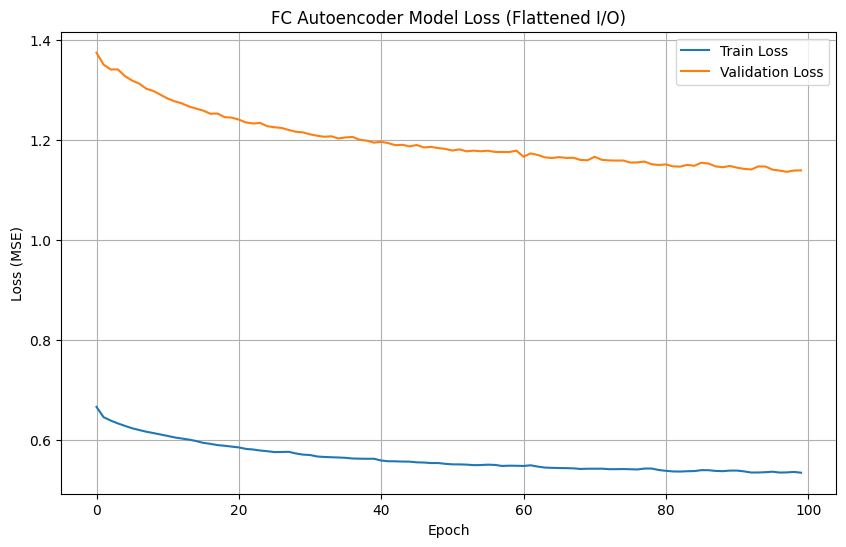


FC Autoencoder training complete (with flattened I/O).


In [7]:
# 4 --- Train the Fully-Connected Autoencoder (FC-AE) - MODIFIED FOR FLATTENED I/O
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np # Make sure numpy is imported

EPOCHS = 100  # Can be adjusted
BATCH_SIZE = 256 # Can be adjusted

# Early stopping callback
early_stopping_fc = EarlyStopping(
    monitor="val_loss",
    patience=10,         # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    restore_best_weights=True
)

# --- Reshape target data to match flattened model output ---
# Original shape: (num_samples, sequence_length, num_features)
# Target shape for flattened AE: (num_samples, sequence_length * num_features)
num_train_samples = X_AE_train_benign_seq.shape[0]
num_val_samples = X_val_seq.shape[0]
flattened_dim = SEQUENCE_LENGTH * NUM_FEATURES # Should be 920

y_AE_train_benign_flat = np.reshape(X_AE_train_benign_seq, (num_train_samples, flattened_dim))
y_val_flat = np.reshape(X_val_seq, (num_val_samples, flattened_dim))

print(f"Reshaped target shapes -> Train: {y_AE_train_benign_flat.shape}, Validation: {y_val_flat.shape}")

print("\nTraining Fully-Connected Autoencoder (autoencoder_fc) with flattened I/O...")
history_fc = autoencoder_fc.fit(
    X_AE_train_benign_seq,    # Input is still sequence shape (model flattens internally)
    y_AE_train_benign_flat,   # Target is now flattened
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(X_val_seq, y_val_flat), # Use sequential input, flattened target for validation
    callbacks=[early_stopping_fc],
    verbose=1
)

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history_fc.history['loss'], label='Train Loss')
plt.plot(history_fc.history['val_loss'], label='Validation Loss')
plt.title('FC Autoencoder Model Loss (Flattened I/O)')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

print("\nFC Autoencoder training complete (with flattened I/O).")


Calculating reconstruction errors...
Reconstruction error calculation complete.

Determining optimal threshold on validation data...
Optimal threshold (max F1 on val): 0.324410 (F1: 0.8833)

Evaluating on the Test Set using the optimal threshold...

Classification Report (Test Set):
                precision    recall  f1-score   support

    Benign (0)       0.33      0.64      0.43     12545
Ransomware (1)       0.68      0.36      0.47     25854

      accuracy                           0.45     38399
     macro avg       0.50      0.50      0.45     38399
  weighted avg       0.56      0.45      0.46     38399

ROC-AUC Score (Test Set): 0.5186


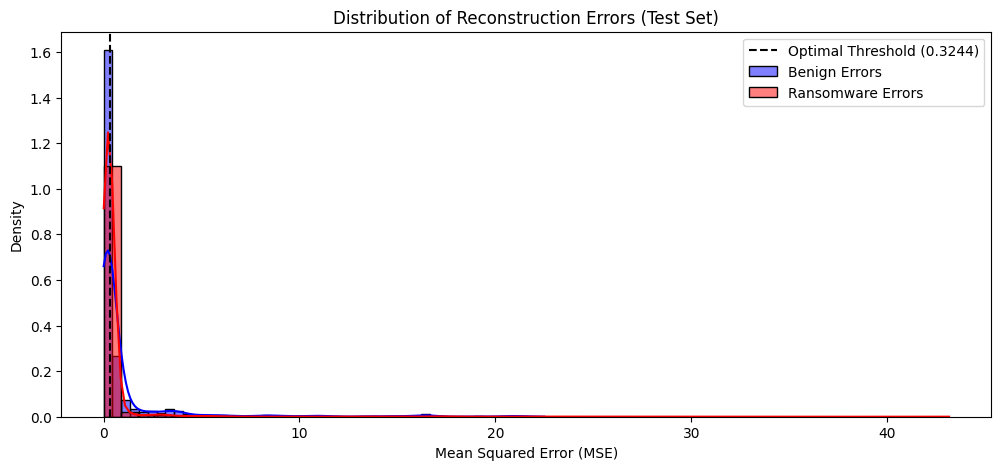

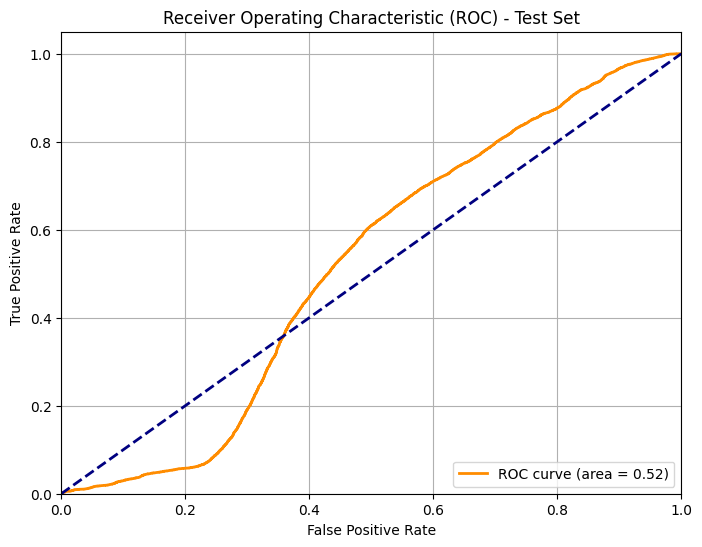

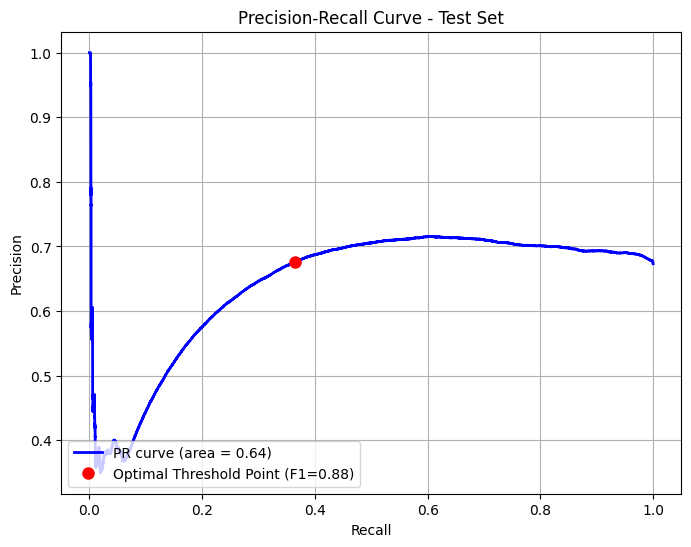

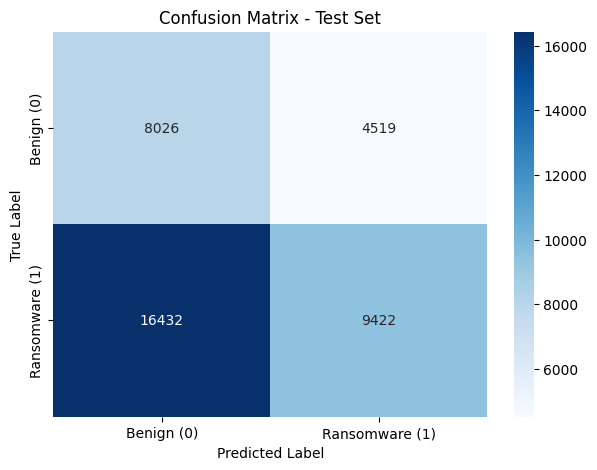

In [8]:
# 5 --- Evaluate the Fully-Connected Autoencoder (FC-AE) - MODIFIED FOR FLATTENED I/O
from sklearn.metrics import mean_squared_error, roc_auc_score, classification_report, confusion_matrix, roc_curve, precision_recall_curve, auc, f1_score
import seaborn as sns # For prettier confusion matrix
import matplotlib.pyplot as plt
import numpy as np # Ensure numpy is imported
import pandas as pd # Ensure pandas is imported

flattened_dim = SEQUENCE_LENGTH * NUM_FEATURES # Should be 920

# --- 1. Calculate Reconstruction Errors ---
print("\nCalculating reconstruction errors...")

# Helper function to reshape and calculate error
def get_flattened_recon_error(model, X_original_seq):
    num_samples = X_original_seq.shape[0]
    # Predict (output should be flattened: shape (?, 920))
    reconstructions_flat = model.predict(X_original_seq, verbose=0)
    # Reshape original sequence to flattened for comparison
    X_original_flat = np.reshape(X_original_seq, (num_samples, flattened_dim))
    # Calculate MSE between flattened original and flattened reconstruction
    recon_errors = np.mean(np.square(X_original_flat - reconstructions_flat), axis=1)
    return recon_errors

# Errors on the (benign) training data used for AE
recon_errors_train_fc = get_flattened_recon_error(autoencoder_fc, X_AE_train_benign_seq)

# Errors on the validation data (contains benign and ransomware sequences)
recon_errors_val_fc = get_flattened_recon_error(autoencoder_fc, X_val_seq)

# Errors on the test data (contains benign and ransomware sequences)
recon_errors_test_fc = get_flattened_recon_error(autoencoder_fc, X_test_seq)

print("Reconstruction error calculation complete.")

# --- 2. Determine Optimal Threshold on Validation Data ---
# Use Precision-Recall curve to find threshold maximizing F1
print("\nDetermining optimal threshold on validation data...")
precision, recall, thresholds = precision_recall_curve(y_val_seq, recon_errors_val_fc)
# Calculate F1 score for each threshold, excluding the last threshold (always 1)
f1_scores = 2 * recall * precision / (recall + precision + 1e-9) # Add epsilon for stability

# Find the threshold that gives the maximum F1 score
optimal_idx = np.argmax(f1_scores[:-1]) # Exclude last value which corresponds to no prediction
optimal_threshold_fc = thresholds[optimal_idx]
max_f1_fc = f1_scores[optimal_idx]

print(f"Optimal threshold (max F1 on val): {optimal_threshold_fc:.6f} (F1: {max_f1_fc:.4f})")

# Alternative: Using percentiles (less optimal but simpler)
# threshold_fc = np.percentile(recon_errors_train_fc, 95) # Example: 95th percentile of benign errors
# print(f"Threshold based on 95th percentile of benign train errors: {threshold_fc:.6f}")

# --- 3. Evaluate on the Test Set using the optimal threshold ---
print("\nEvaluating on the Test Set using the optimal threshold...")
y_pred_test_fc = (recon_errors_test_fc > optimal_threshold_fc).astype(int)

print("\nClassification Report (Test Set):")
print(classification_report(y_test_seq, y_pred_test_fc, target_names=['Benign (0)', 'Ransomware (1)']))

try:
    roc_auc_test = roc_auc_score(y_test_seq, recon_errors_test_fc)
    print(f"ROC-AUC Score (Test Set): {roc_auc_test:.4f}")
except ValueError as e:
    print(f"Could not calculate ROC-AUC: {e}")


# --- 4. Plotting ---

# Plot Histograms of Reconstruction Errors
plt.figure(figsize=(12, 5))
sns.histplot(recon_errors_test_fc[y_test_seq == 0], bins=50, kde=True, color='blue', label='Benign Errors', stat='density')
sns.histplot(recon_errors_test_fc[y_test_seq == 1], bins=50, kde=True, color='red', label='Ransomware Errors', stat='density')
plt.axvline(optimal_threshold_fc, color='black', linestyle='--', label=f'Optimal Threshold ({optimal_threshold_fc:.4f})')
plt.title('Distribution of Reconstruction Errors (Test Set)')
plt.xlabel('Mean Squared Error (MSE)')
plt.ylabel('Density')
plt.legend()
plt.show()

# Plot ROC Curve
fpr, tpr, roc_thresholds = roc_curve(y_test_seq, recon_errors_test_fc)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Test Set')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Plot Precision-Recall Curve
precision, recall, pr_thresholds = precision_recall_curve(y_test_seq, recon_errors_test_fc)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
# Find the point corresponding to the optimal threshold (closest threshold)
closest_threshold_idx = np.argmin(np.abs(pr_thresholds - optimal_threshold_fc))
# Need to handle edge case where optimal_threshold might be higher than max threshold
if closest_threshold_idx >= len(recall): closest_threshold_idx = len(recall) - 1
if closest_threshold_idx >= len(precision): closest_threshold_idx = len(precision) - 1

plt.plot(recall[closest_threshold_idx], precision[closest_threshold_idx], 'ro', markersize=8, label=f'Optimal Threshold Point (F1={max_f1_fc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Test Set')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()


# Plot Confusion Matrix
cm_test = confusion_matrix(y_test_seq, y_pred_test_fc)
plt.figure(figsize=(7, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign (0)', 'Ransomware (1)'],
            yticklabels=['Benign (0)', 'Ransomware (1)'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Test Set")
plt.show()


In [27]:
# 6 --- Define and compile the LSTM-based Variational Autoencoder (LSTM-VAE) - Using Custom KL Layer
from tensorflow.keras import layers, Model, Input, backend as K
from tensorflow.keras.layers import Layer, LSTM, Dense, TimeDistributed, RepeatVector, Lambda
import tensorflow as tf # Import tensorflow for eager operations within the custom layer if needed

# Latent dimension for the VAE
LATENT_DIM_VAE = 16 # Can be adjusted

# --- Custom Layer for KL Divergence ---
class KLDivergenceLayer(Layer):
    """ Identity transform layer that adds KL divergence
        to the final model loss.
    """
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(**kwargs)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        kl_batch = -0.5 * K.sum(1 + z_log_var -
                                K.square(z_mean) -
                                K.exp(z_log_var), axis=-1)
        # Add the KL loss for the batch using add_loss - REMOVED inputs=inputs
        self.add_loss(K.mean(kl_batch) / (SEQUENCE_LENGTH * NUM_FEATURES)) # Scale KL loss
        # Return one of the inputs to maintain the symbolic connection if needed elsewhere,
        # though its main purpose here is the loss side-effect.
        return z_mean# Or could return inputs, doesn't matter for loss calculation side effect


# --- Encoder ---
vae_seq_input = Input(shape=(SEQUENCE_LENGTH, NUM_FEATURES), name="vae_seq_input")
encoder_lstm = LSTM(128, activation='tanh', name="encoder_lstm")(vae_seq_input)
z_mean = Dense(LATENT_DIM_VAE, name="z_mean")(encoder_lstm)
z_log_var = Dense(LATENT_DIM_VAE, name="z_log_var")(encoder_lstm)

# Add the KL Divergence layer, calculating and adding the loss
z_mean_with_kl_loss = KLDivergenceLayer(name='kl_divergence')([z_mean, z_log_var])
# Note: z_mean_with_kl_loss is essentially z_mean, but the layer added the loss

# Sampling function needs z_mean and z_log_var, which are available BEFORE the KL layer side-effect
def sampling(args):
    z_mean_sample, z_log_var_sample = args
    batch = K.shape(z_mean_sample)[0]
    dim = K.int_shape(z_mean_sample)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean_sample + K.exp(0.5 * z_log_var_sample) * epsilon

z = Lambda(sampling, output_shape=(LATENT_DIM_VAE,), name='z')([z_mean, z_log_var]) # Sample using original z_mean, z_log_var

# Instantiate Encoder model (Optional, if needed separately)
# The main VAE below implicitly contains the encoder logic
# encoder_vae = Model(vae_seq_input, [z_mean, z_log_var, z], name="Encoder_VAE")
# print("--- Encoder VAE Summary ---")
# encoder_vae.summary()

# --- Decoder ---
latent_inputs = Input(shape=(LATENT_DIM_VAE,), name='z_sampling')
repeated_latent = RepeatVector(SEQUENCE_LENGTH)(latent_inputs)
decoder_lstm = LSTM(128, activation='tanh', return_sequences=True, name="decoder_lstm")(repeated_latent)
vae_seq_output = TimeDistributed(Dense(NUM_FEATURES, activation='linear'), name="vae_seq_output")(decoder_lstm)

# Instantiate Decoder model
decoder_vae = Model(latent_inputs, vae_seq_output, name="Decoder_VAE")
print("\n--- Decoder VAE Summary ---")
decoder_vae.summary()

# --- VAE Model (linking Encoder parts and Decoder) ---
# Build the VAE using the input, the KL calculation layer's output (which includes the loss),
# the sampling output 'z', and the decoder.
# We take the input, run through encoder layers *including* the KL layer to register the loss,
# but then feed the *sampled* z (derived from the original z_mean/z_log_var) into the decoder.
_ = KLDivergenceLayer(name='kl_divergence_model')([z_mean, z_log_var]) # Pass z_mean, z_log_var to register the loss calculation within the main model graph
vae_outputs = decoder_vae(z) # Pass the sampled 'z' to the decoder
vae = Model(vae_seq_input, vae_outputs, name='VAE_LSTM')


# --- Compile VAE ---
# Compile with MSE for reconstruction loss. Keras handles this automatically.
# The KL loss is added via the custom KLDivergenceLayer's add_loss method.
vae.compile(optimizer='adam', loss='mse')

print("\n--- VAE (Combined) Summary ---")
vae.summary()

print(f"\nLSTM-VAE using Sequence Length: {SEQUENCE_LENGTH}, Features: {NUM_FEATURES}, Latent Dim: {LATENT_DIM_VAE}")
print("Compiled with 'mse' reconstruction loss and added KL divergence loss via custom layer.")



--- Decoder VAE Summary ---


Model: "Decoder_VAE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ z_sampling (InputLayer)         │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_3 (RepeatVector)  │ (None, 40, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_lstm (LSTM)             │ (None, 40, 128)        │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vae_seq_output                  │ (None, 40, 23)         │         2,967 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,207 (301.59 KB)

 Trainable params: 77,207 (301.59 KB)

 Non-trainable params: 0 (0.00 B)


--- VAE (Combined) Summary ---


Model: "VAE_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ vae_seq_input       │ (None, 40, 23)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ (None, 128)       │     77,824 │ vae_seq_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 16)        │      2,064 │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 16)        │      2,064 │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 16)        │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_VAE         │ (None, 40, 23)    │     77,207 │ z[0][0]           │
│ (Functional)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 159,159 (621.71 KB)

 Trainable params: 159,159 (621.71 KB)

 Non-trainable params: 0 (0.00 B)


LSTM-VAE using Sequence Length: 40, Features: 23, Latent Dim: 16
Compiled with 'mse' reconstruction loss and added KL divergence loss via custom layer.


In [28]:
# 7 --- Train the LSTM-based Variational Autoencoder (VAE)
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

EPOCHS_VAE = 100  # Adjust as needed
BATCH_SIZE_VAE = 256 # Adjust as needed

# Early stopping callback for VAE
early_stopping_vae = EarlyStopping(
    monitor="val_loss",
    patience=10,  # Increase patience maybe? VAEs can take longer
    verbose=1,
    restore_best_weights=True
)

print("\nTraining LSTM-based Variational Autoencoder (vae)...")

# Train the VAE using the benign sequences
# Input and Target are the same: X_AE_train_benign_seq
# Validation uses X_val_seq to see how it reconstructs varied sequences
history_vae = vae.fit(
    X_AE_train_benign_seq,
    X_AE_train_benign_seq, # Target is reconstruction of input
    epochs=EPOCHS_VAE,
    batch_size=BATCH_SIZE_VAE,
    shuffle=True,
    validation_data=(X_val_seq, X_val_seq), # Input and Target for validation
    callbacks=[early_stopping_vae],
    verbose=1
)

# Plot training & validation loss values
# Note: Loss here includes both MSE (reconstruction) and the KL divergence term
plt.figure(figsize=(10, 6))
plt.plot(history_vae.history['loss'], label='Train Loss (MSE + KL)')
plt.plot(history_vae.history['val_loss'], label='Validation Loss (MSE + KL)')
plt.title('LSTM-VAE Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

print("\nLSTM-VAE training complete.")


Training LSTM-based Variational Autoencoder (vae)...
Epoch 1/100
 35/257 ━━━━━━━━━━━━━━━━━━━━ 1:43 465ms/step - loss: 0.7374

KeyboardInterrupt: 